<p style="display:flex; align-items:center;">
  <img src="https://upload.wikimedia.org/wikipedia/it/1/11/Napoli_university_seal_alfachannel.png"
       alt="Logo UNINA" width="10%" style="margin-right:2%;">
  <img src="https://indico.unina.it/event/58/attachments/172/352/logo_dieti.png"
       alt="Logo DIETI" width="10%">
</p>


# Hierarchical Intrusion Detection

---

***Practical Network Intrusion Detection with Machine Learning and Generative AI***

Prof. Giampaolo Bovenzi


In [45]:
# Colab bootstrap
import os, sys, subprocess, importlib, pathlib

REPO_URL = "https://github.com/jmpr0/practical-nids"
REPO_DIR = "/content/practical-nids"

if not pathlib.Path(REPO_DIR).exists():
    subprocess.run(["git", "clone", REPO_URL, REPO_DIR], check=True)

os.chdir(REPO_DIR)

# Install deps
subprocess.run([sys.executable, "-m", "pip", "install", "-r", "/content/practical-nids/requirements.txt", "--quiet"], check=True)

# Create outputs dirs
for d in ["outputs", "data/cache", "models"]:
    pathlib.Path(d).mkdir(parents=True, exist_ok=True)

print("Setup OK in", os.getcwd())


fatal: could not create leading directories of '/content/practical-nids': Permission denied


CalledProcessError: Command '['git', 'clone', 'https://github.com/jmpr0/practical-nids', '/content/practical-nids']' returned non-zero exit status 128.

## Library imports

In [335]:
# Hold-out dataset function
from sklearn.model_selection import train_test_split

# Classification metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Plotting and data-handling
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import os

In [336]:
data_dir = 'dataset/CICAndMal2017'

## Data Loader Module
This module handles loading and preprocessing of datasets for misuse detection.

In [337]:
def load_json():
    categories = ["SMSMalware", "Ransomware", "Adware", "Scareware"]
    features = [
        "pkt_length", "iat", "biflow_volume", "biflow_duration",
        "n_packets", "fwd_n_packets", "bwd_n_packets",
        "fwd_volume", "bwd_volume"
    ]

    json_data, data, target = {}, [], []

    def compute_stats(values):
        """Return basic statistics and percentiles on a list of numeric values."""
        if not values:
            return [0] * 10
        return [
            np.mean(values), np.max(values), np.min(values),
            np.percentile(values, 25), np.percentile(values, 75),
            np.percentile(values, 50), np.percentile(values, 60),
            np.percentile(values, 95), np.std(values), np.var(values)
        ]

    def build_file_list():
        """Builds the list of files to load based on level and balancing."""
        files = []
        for category in categories:
            fname = f"{data_dir}/Category/{category}_100smplXfam.json"
            files.append(fname)
        return files

    # Initial load of benign data
    benign_data = json.load(open(f"{data_dir}/Category/Benign_4200smpl.json"))
    print(len(benign_data), f'samples in {data_dir}/Category/Benign_4200smpl.json')
    json_data.update(benign_data)

    # List of files to load
    files = build_file_list()
    for file in files:
        add_dict = json.load(open(file))
        print(len(add_dict), f'samples in {file}')
        json_data.update(add_dict)

    print('Extracting features and labels...')
    for _, qdata in json_data.items():
        quintuple_data = []
        label = qdata["label"]

        for feature in features:
            value = qdata.get(feature, 0)

            if feature == "pkt_length":
                directions = qdata["direction"]
                fwd = [v for v, d in zip(value, directions) if d]
                bwd = [v for v, d in zip(value, directions) if not d]

                quintuple_data.extend(compute_stats(fwd))
                quintuple_data.extend(compute_stats(bwd))
                quintuple_data.extend(compute_stats(value))

            elif feature == "iat":
                quintuple_data.extend(compute_stats(value))

            else:
                quintuple_data.append(0 if value == '' else value)

        data.append(quintuple_data)
        target.append(label)

    return data, target


## Misuse Detector Implementation
This base class implements different ML classifiers

In [338]:
class Classifier:
    def __init__(self, classifier):
        models = {
            "Decision Tree": DecisionTreeClassifier(),
            "Naive Bayes": MultinomialNB(),
            "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
            "Random Forest": RandomForestClassifier(n_estimators=100)
        }
        self.model = models.get(classifier, models["Random Forest"])

    def fit(self, X, y):
        self.model.fit(X, y)

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)


### Function to convert a set of raw labels (of the form Category_Family) into labels per level
- level = 0 -> binary (Benign/Malware)
- level = 1 -> category
- level = 2 -> family

In [339]:
def smart_labeling(raw_labels, level=0):
    """
    Convert the original labels into labels for the specified level:
      level = 0 -> binary
      level = 1 -> category
      level = 2 -> family
    Returns (labels, true_labels)
    """
    level_labels = []

    for elem in raw_labels:
        if elem == "Benign":
            level_labels.append("Benign")
        else:
            if level == 0:
                level_labels.append("Malware")
            elif level == 1:
                level_labels.append(elem.split('_')[0])
            else:  # level == 2
                level_labels.append(elem.split('_')[1])

    return level_labels


## Estrazione dei dati - Livello binario

In [340]:
# Training set for the root node and corresponding labels
X, y = load_json()

4200 samples in dataset/CICAndMal2017/Category/Benign_4200smpl.json
1100 samples in dataset/CICAndMal2017/Category/SMSMalware_100smplXfam.json
1000 samples in dataset/CICAndMal2017/Category/Ransomware_100smplXfam.json
1000 samples in dataset/CICAndMal2017/Category/Adware_100smplXfam.json
1100 samples in dataset/CICAndMal2017/Category/Scareware_100smplXfam.json
Extracting features and labels...


In [341]:
# Single train-test split of dataset based on the family stratification
stratify = smart_labeling(y, 2)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.70, random_state=42, stratify=stratify)

# Construction of per-level material
# L0: BEN vs MAL
l0_Xtrain, l0_Xtest = Xtrain, Xtest
l0_ytrain, l0_ytest = smart_labeling(ytrain, 0), smart_labeling(ytest, 0)

# L1: CAT (filter out benign traffic)
l1_Xtrain = [x for x, l in zip(l0_Xtrain, l0_ytrain) if l != 'Benign']
l1_ytrain = smart_labeling([l for l in ytrain if l != 'Benign'], 1)
# Per-node test sets (isolated evaluation)
l1_Xtest_full = [x for x, l in zip(l0_Xtest, l0_ytest) if l != 'Benign']
l1_ytest_full = smart_labeling([l for l in ytest if l != 'Benign'], 1)

assert len(l1_Xtrain) == len(l1_ytrain)
assert len(l1_Xtest_full) == len(l1_ytest_full)

# L2: FAM (build one dataset for each family)
categories = ["SMSMalware", "Ransomware", "Adware", "Scareware"]
l2_Xtrain, l2_ytrain = {}, {}
l2_Xtest_full, l2_ytest_full = {}, {}
for category in categories:
    l2_Xtrain[category] = [x for x, l in zip(l1_Xtrain, l1_ytrain) if category in l]
    l2_ytrain[category] = smart_labeling([l for l in ytrain if category in l], 2)

    l2_Xtest_full[category] = [x for x, l in zip(l1_Xtest_full, l1_ytest_full) if category in l]
    l2_ytest_full[category] = smart_labeling([l for l in ytest if category in l], 2)

    assert len(l2_Xtrain[category]) == len(l2_ytrain[category]), f'{len(l2_Xtrain[category])=} {len(l2_ytrain[category])=}'
    assert len(l2_Xtest_full[category]) == len(l2_ytest_full[category]), f'{len(l2_Xtest_full[category])=} {len(l2_ytest_full[category])=}'
    

### Training of the Root classifier

In [342]:
# Definition and training of the classifier
binary_classifier = Classifier("Random Forest")
binary_classifier.fit(l0_Xtrain, l0_ytrain)

### Testing of the Root classifier

#### Execution

              precision    recall  f1-score   support

      Benign       0.58      0.60      0.59      1260
     Malware       0.59      0.57      0.58      1260

    accuracy                           0.59      2520
   macro avg       0.59      0.59      0.59      2520
weighted avg       0.59      0.59      0.59      2520



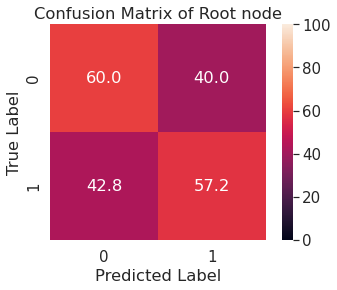

In [343]:
# Predictions
l0_pred = binary_classifier.predict(l0_Xtest)
l0_soft_pred = binary_classifier.predict_proba(l0_Xtest)

# Metrics
print(classification_report(l0_ytest, l0_pred))

# Confusion matrix
mat = confusion_matrix(l0_ytest, l0_pred, normalize='true')
plt.figure(figsize=(6, 4), dpi=70)
sns.heatmap(mat * 100, square=True, annot=True, vmin=0, vmax=100, fmt='.1f', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Root node')
plt.show()


#### Filtering of quintuples (IMPORTANT: for the RO block this is the part to modify!)

In [344]:
# Building the test set of the L1
l1_Xtest = []
l1_ytest = []

l0_ben_y = []  # Predicted as benign (inference stop)

# Discarded samples
l1_disc_y = []
l1_disc_p = []

# threshold = 0.5
threshold = 0.0

for i in range(len(l0_pred)):
    if np.max(l0_soft_pred[i]) < threshold:  # End of inference
        l1_disc_y.append(l0_ytest[i])
        l1_disc_p.append(l0_pred[i])
    elif l0_pred[i] == 'Malware':
        l1_Xtest.append(l0_Xtest[i])
        l1_ytest.append(ytest[i])
    else:  # End of inference (classified as Benign)
        l0_ben_y.append(ytest[i])

l1_ytest_multilabel = l1_ytest.copy()
l1_ytest = smart_labeling(l1_ytest, level=1)
l0_ben_y = smart_labeling(l0_ben_y, level=2)  # Needed to take leaf node labels of samples classified as benign

print("Root node test")
print("Number of quintuples tested: " + str(len(l0_ytest)))
print("Number of quintuples classified as Malware: " + str(len(l1_ytest)))
print("Number of quintuples discarded: " + str(len(l1_disc_y)))
print("Number of quintuples classified as Benign: " + str(len(l0_ben_y)))

Root node test
Number of quintuples tested: 2520
Number of quintuples classified as Malware: 1225
Number of quintuples discarded: 0
Number of quintuples classified as Benign: 1295


### Data extraction - Category level

In [345]:
from collections import Counter

# Summary and sanity checks for the training subset of the Malware node
print("Number of samples selected for Malware node:", len(l1_Xtrain))
print("First 20 labels in the subset:", l1_ytrain[:20])

# Sanity checks
if len(l1_Xtrain) != len(l1_ytrain):
    raise ValueError("Data/target length mismatch for category training subset")

category_counts = Counter(lbl.split("_")[0] for lbl in l1_ytrain)
print("Counts per category in the training subset:", dict(category_counts))

Number of samples selected for Malware node: 2940
First 20 labels in the subset: ['Ransomware', 'SMSMalware', 'Scareware', 'Adware', 'SMSMalware', 'Ransomware', 'Scareware', 'Adware', 'Ransomware', 'Ransomware', 'Ransomware', 'Scareware', 'Scareware', 'Adware', 'Adware', 'Ransomware', 'Scareware', 'Adware', 'Ransomware', 'Scareware']
Counts per category in the training subset: {'Ransomware': 700, 'SMSMalware': 770, 'Scareware': 770, 'Adware': 700}


### Training of the Malware classifier

In [346]:
# Definition and training of a classifier
category_classifier = Classifier("Random Forest")
category_classifier.fit(l1_Xtrain, l1_ytrain)

### Malware node testing

#### Propagated Error Evaluation (Cascade)

Number of samples in test: 1225
              precision    recall  f1-score   support

      Adware       0.28      0.41      0.33       176
      Benign       0.00      0.00      0.00       504
  Ransomware       0.29      0.49      0.36       170
  SMSMalware       0.33      0.54      0.41       213
   Scareware       0.15      0.30      0.20       162

    accuracy                           0.26      1225
   macro avg       0.21      0.35      0.26      1225
weighted avg       0.16      0.26      0.20      1225



/home/jmpr/miniconda3/envs/ntg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmpr/miniconda3/envs/ntg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmpr/miniconda3/envs/ntg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


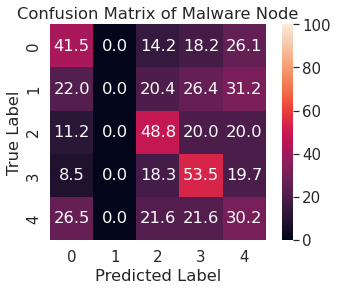

In [347]:
print(f"Number of samples in test: {len(l1_ytest)}")

# Predictions
l1_pred = category_classifier.predict(l1_Xtest)
l1_soft_pred = category_classifier.predict_proba(l1_Xtest)

# Evaluation metrics
print(classification_report(l1_ytest, l1_pred))

# Confusion matrix
mat = confusion_matrix(l1_ytest, l1_pred, normalize='true')
plt.figure(figsize=(6, 4), dpi=70)
sns.heatmap(mat * 100, square=True, annot=True, vmin=0, vmax=100, fmt='.1f', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Malware Node')
plt.show()


#### Isolated Evaluation

Number of samples in test full: 1260
              precision    recall  f1-score   support

      Adware       0.39      0.34      0.36       300
  Ransomware       0.38      0.38      0.38       300
  SMSMalware       0.46      0.47      0.47       330
   Scareware       0.30      0.33      0.32       330

    accuracy                           0.38      1260
   macro avg       0.38      0.38      0.38      1260
weighted avg       0.38      0.38      0.38      1260



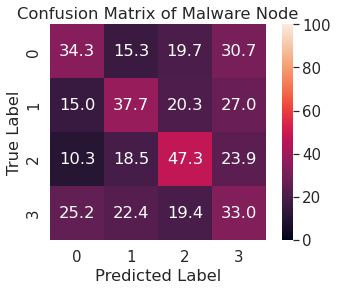

In [348]:
print(f"Number of samples in test full: {len(l1_ytest_full)}")

# Predictions
l1_pred_full = category_classifier.predict(l1_Xtest_full)
l1_soft_pred_full = category_classifier.predict_proba(l1_Xtest_full)

# Evaluation metrics
print(classification_report(l1_ytest_full, l1_pred_full))

# Confusion matrix
mat = confusion_matrix(l1_ytest_full, l1_pred_full, normalize='true')
plt.figure(figsize=(6, 4), dpi=70)
sns.heatmap(mat * 100, square=True, annot=True, vmin=0, vmax=100, fmt='.1f', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Malware Node')
plt.show()


#### Quintuple/samples filtering

In [349]:
# Building the test set of the L2
l2_Xtest = {}
l2_ytest = {}

# Discarded samples
l2_disc_y = []
l2_disc_p = []

# threshold = 0.8
thresold = 0.0

print("Malware node test")
print("Number of quintuples tested: " + str(len(l1_ytest)))

for category in categories:

    l2_Xtest[category], l2_ytest[category] = [], []

    for i in range(len(l1_pred)):
        if category in l1_pred[i] and np.max(l1_soft_pred[i]) >= threshold:
            l2_Xtest[category].append(l1_Xtest[i])
            l2_ytest[category].append(l1_ytest_multilabel[i])
        elif category in l1_pred[i]:  # End of inference
            l2_disc_y.append(l1_ytest[i])
            l2_disc_p.append(l1_pred[i])

    l2_ytest[category] = smart_labeling(l2_ytest[category], level=2)

    print(f"Number of quintuples classified as {category}: " + str(len(l2_ytest[category])))
print("Number of quintuples discarded: " + str(len(l1_disc_y)))

Malware node test
Number of quintuples tested: 1225
Number of quintuples classified as SMSMalware: 348
Number of quintuples classified as Ransomware: 285
Number of quintuples classified as Adware: 264
Number of quintuples classified as Scareware: 328
Number of quintuples discarded: 0


### Leaf Nodes Classifiers Training

#### Adware

In [350]:
# Definition and training of a classifier
Adware_classifier = Classifier("Random Forest")
Adware_classifier.fit(l2_Xtrain['Adware'], l2_ytrain['Adware'])

#### Ransomware

In [351]:
# Definition and training of a classifier
Ransomware_classifier = Classifier("Random Forest")
Ransomware_classifier.fit(l2_Xtrain['Ransomware'], l2_ytrain['Ransomware'])

#### Scareware

In [352]:
# Definition and training of a classifier
Scareware_classifier = Classifier("Random Forest")
Scareware_classifier.fit(l2_Xtrain['Scareware'], l2_ytrain['Scareware'])

#### SMS Malware

In [353]:
# Definition and training of a classifier
SMSMalware_classifier = Classifier("Random Forest")
SMSMalware_classifier.fit(l2_Xtrain['SMSMalware'], l2_ytrain['SMSMalware'])

#### Adware

Number of Adware quintuples: 264
First 20 Adware labels: ['Benign', 'Benign', 'Benign', 'Benign', 'AndroidDefender', 'Benign', 'Benign', 'Koodous', 'AndroidSpy.277', 'Selfmite', 'Shuanet', 'AVforandroid', 'Benign', 'Benign', 'RansomBO', 'Koodous', 'Benign', 'Benign', 'Gooligan', 'Benign']
Number of quintuples after smart labeling: 264
                 precision    recall  f1-score   support

   AVforandroid       0.00      0.00      0.00         7
         AVpass       0.00      0.00      0.00         2
AndroidDefender       0.00      0.00      0.00         5
 AndroidSpy.277       0.00      0.00      0.00         5
        Beanbot       0.00      0.00      0.00         2
         Benign       0.00      0.00      0.00       111
          Biige       0.00      0.00      0.00         1
        Charger       0.00      0.00      0.00         2
         Dowgin       0.10      0.33      0.15        12
          Ewind       0.07      0.25      0.11         8
         FakeAV       0.00      0.0

/home/jmpr/miniconda3/envs/ntg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmpr/miniconda3/envs/ntg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmpr/miniconda3/envs/ntg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


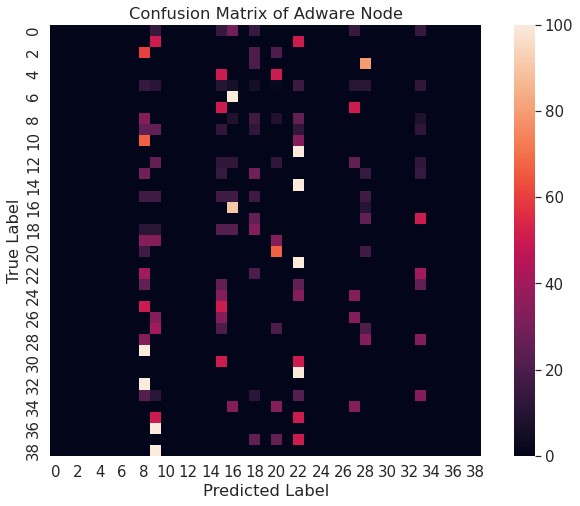

In [365]:
Ad_Xtest, Ad_ytest = l2_Xtest['Adware'], l2_ytest['Adware']

print(f"Number of Adware quintuples: {len(Ad_ytest)}")
print("First 20 Adware labels:", Ad_ytest[0:20])

print(f"Number of quintuples after smart labeling: {len(Ad_ytest)}")

# Prediction
Adware_pred = Adware_classifier.predict(Ad_Xtest)

# Evaluation
score = accuracy_score(Ad_ytest, Adware_pred)
print(classification_report(Ad_ytest, Adware_pred))
print(f"Accuracy: {score:.4f}")

# Confusion matrix
mat = confusion_matrix(Ad_ytest, Adware_pred, normalize='true')
plt.figure(figsize=(12, 8), dpi=70)
sns.heatmap(mat*100, square=True, annot=False, fmt='.1f', vmin=0, vmax=100, cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Adware Node')
plt.show()


Number of Adware quintuples: 300
First 20 Adware labels: ['Selfmite', 'Ewind', 'Koodous', 'Shuanet', 'Selfmite', 'Gooligan', 'Koodous', 'Selfmite', 'Feiwo', 'Mobidash', 'Shuanet', 'Feiwo', 'Mobidash', 'Ewind', 'Koodous', 'Shuanet', 'Mobidash', 'Gooligan', 'Feiwo', 'Shuanet']
Number of quintuples after smart labeling: 300
              precision    recall  f1-score   support

      Dowgin       0.18      0.23      0.20        30
       Ewind       0.22      0.27      0.24        30
       Feiwo       0.23      0.23      0.23        30
    Gooligan       0.46      0.37      0.41        30
      Kemoge       0.19      0.20      0.19        30
     Koodous       0.26      0.23      0.25        30
    Mobidash       0.12      0.10      0.11        30
    Selfmite       0.07      0.07      0.07        30
     Shuanet       0.20      0.17      0.18        30
       Youmi       0.21      0.20      0.20        30

    accuracy                           0.21       300
   macro avg       0.21    

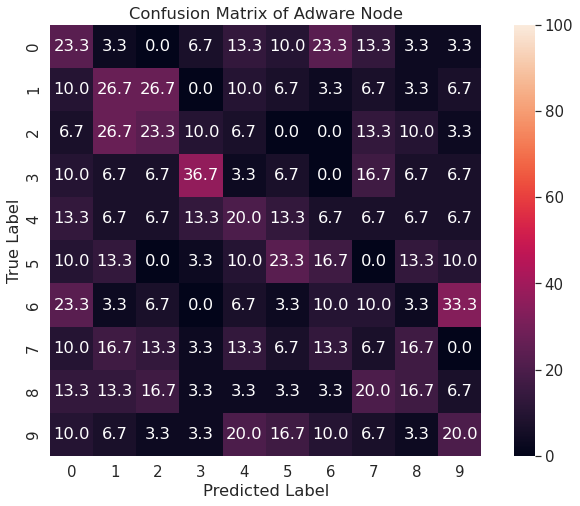

In [366]:
Ad_Xtest_full, Ad_ytest_full = l2_Xtest_full['Adware'], l2_ytest_full['Adware']

print(f"Number of Adware quintuples: {len(Ad_ytest_full)}")
print("First 20 Adware labels:", Ad_ytest_full[0:20])

print(f"Number of quintuples after smart labeling: {len(Ad_ytest_full)}")

# Prediction
Adware_pred_full = Adware_classifier.predict(Ad_Xtest_full)

# Evaluation
score = accuracy_score(Ad_ytest_full, Adware_pred_full)
print(classification_report(Ad_ytest_full, Adware_pred_full))
print(f"Accuracy: {score:.4f}")

# Confusion matrix
mat = confusion_matrix(Ad_ytest_full, Adware_pred_full, normalize='true')
plt.figure(figsize=(12, 8), dpi=70)
sns.heatmap(mat*100, square=True, annot=True, fmt='.1f', vmin=0, vmax=100, cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Adware Node')
plt.show()


#### Ransomware

Number of Ransomware quintuples: 285
Number of quintuples after smart labeling: 285
                 precision    recall  f1-score   support

   AVforandroid       0.00      0.00      0.00         3
         AVpass       0.00      0.00      0.00         4
AndroidDefender       0.00      0.00      0.00         2
 AndroidSpy.277       0.00      0.00      0.00         3
        Beanbot       0.00      0.00      0.00         3
         Benign       0.00      0.00      0.00       103
          Biige       0.00      0.00      0.00         5
        Charger       0.00      0.00      0.00         4
          Ewind       0.00      0.00      0.00         2
         FakeAV       0.00      0.00      0.00         3
        FakeApp       0.00      0.00      0.00         3
     FakeApp.AL       0.00      0.00      0.00         2
   FakeJobOffer       0.00      0.00      0.00         4
     FakeTaoBao       0.00      0.00      0.00         3
          Feiwo       0.00      0.00      0.00         1
   

/home/jmpr/miniconda3/envs/ntg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmpr/miniconda3/envs/ntg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmpr/miniconda3/envs/ntg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


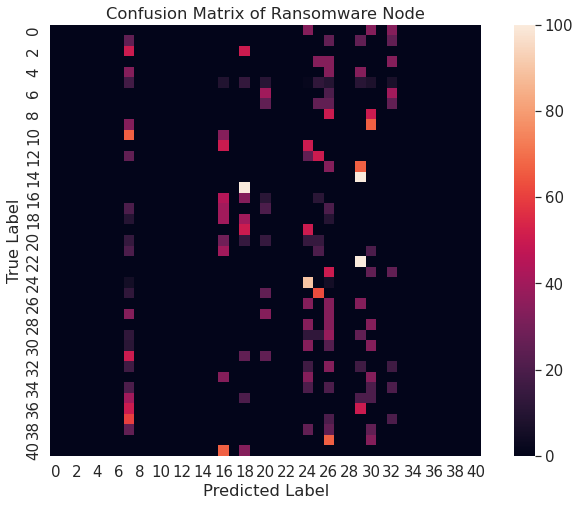

In [367]:
Ra_Xtest, Ra_ytest = l2_Xtest['Ransomware'], l2_ytest['Ransomware']

print(f"Number of Ransomware quintuples: {len(Ra_ytest)}")
print(f"Number of quintuples after smart labeling: {len(Ra_ytest)}")

# Prediction
Ransomware_pred = Ransomware_classifier.predict(Ra_Xtest)

# Evaluation
score = accuracy_score(Ra_ytest, Ransomware_pred)
print(classification_report(Ra_ytest, Ransomware_pred))
print(f"Accuracy: {score:.4f}")

# Confusion matrix
mat = confusion_matrix(Ra_ytest, Ransomware_pred, normalize='true')
plt.figure(figsize=(12, 8), dpi=70)
sns.heatmap(mat*100, square=True, annot=False, fmt='.1f', vmin=0, vmax=100, cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Ransomware Node')
plt.show()


Number of Ransomware quintuples: 300
Number of quintuples after smart labeling: 300
              precision    recall  f1-score   support

     Charger       0.07      0.07      0.07        30
       Jisut       0.28      0.37      0.31        30
       Koler       0.19      0.20      0.19        30
   LockerPin       0.04      0.03      0.04        30
      Pletor       0.59      0.77      0.67        30
   PornDroid       0.23      0.17      0.19        30
    RansomBO       0.21      0.30      0.25        30
  Simplocker       0.23      0.17      0.19        30
      Svpeng       0.32      0.27      0.29        30
 WannaLocker       0.13      0.10      0.11        30

    accuracy                           0.24       300
   macro avg       0.23      0.24      0.23       300
weighted avg       0.23      0.24      0.23       300

Accuracy: 0.2433


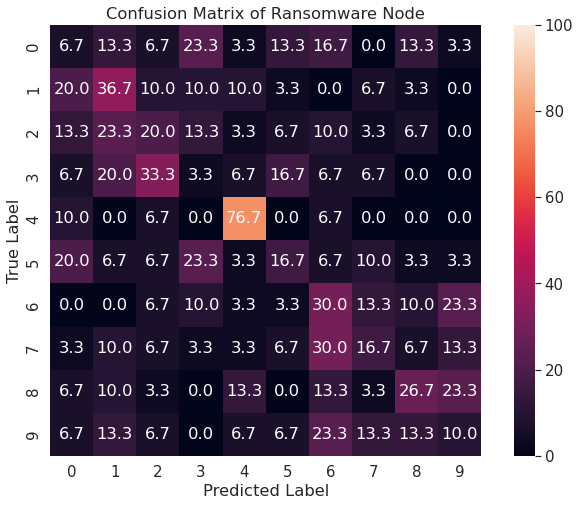

In [368]:
Ra_Xtest_full, Ra_ytest_full = l2_Xtest_full['Ransomware'], l2_ytest_full['Ransomware']

print(f"Number of Ransomware quintuples: {len(Ra_ytest_full)}")
print(f"Number of quintuples after smart labeling: {len(Ra_ytest_full)}")

# Prediction
Ransomware_pred_full = Ransomware_classifier.predict(Ra_Xtest_full)

# Evaluation
score = accuracy_score(Ra_ytest_full, Ransomware_pred_full)
print(classification_report(Ra_ytest_full, Ransomware_pred_full))
print(f"Accuracy: {score:.4f}")

# Confusion matrix
mat = confusion_matrix(Ra_ytest_full, Ransomware_pred_full, normalize='true')
plt.figure(figsize=(12, 8), dpi=70)
sns.heatmap(mat*100, square=True, annot=True, fmt='.1f', vmin=0, vmax=100, cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Ransomware Node')
plt.show()


#### Scareware

Number of Scareware quintuples: 328
Number of quintuples after smart labeling: 328
                 precision    recall  f1-score   support

   AVforandroid       0.07      0.50      0.12         4
         AVpass       0.04      0.12      0.06         8
AndroidDefender       0.06      0.40      0.10         5
 AndroidSpy.277       0.09      0.25      0.13         8
        Beanbot       0.00      0.00      0.00         4
         Benign       0.00      0.00      0.00       157
          Biige       0.00      0.00      0.00         5
        Charger       0.00      0.00      0.00         3
         Dowgin       0.00      0.00      0.00         3
          Ewind       0.00      0.00      0.00         7
         FakeAV       0.06      0.33      0.10         3
        FakeApp       0.03      0.33      0.06         3
     FakeApp.AL       0.03      0.25      0.05         4
   FakeJobOffer       0.00      0.00      0.00         2
     FakeTaoBao       0.00      0.00      0.00         5
    

/home/jmpr/miniconda3/envs/ntg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmpr/miniconda3/envs/ntg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmpr/miniconda3/envs/ntg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


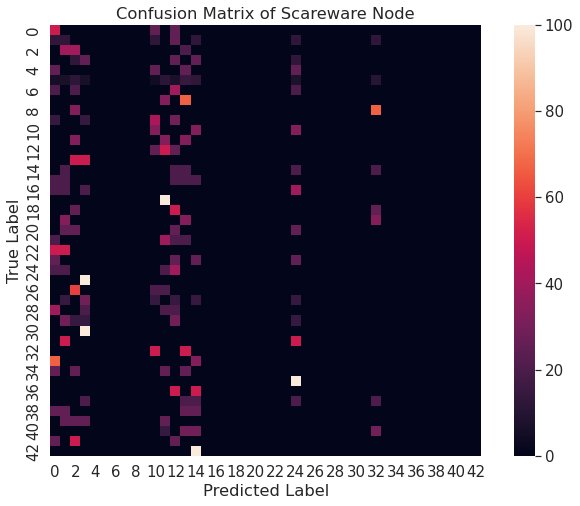

In [369]:
Sc_Xtest, Sc_ytest = l2_Xtest['Scareware'], l2_ytest['Scareware']

print(f"Number of Scareware quintuples: {len(Sc_ytest)}")

print(f"Number of quintuples after smart labeling: {len(Sc_ytest)}")

# Prediction
Scareware_pred = Scareware_classifier.predict(Sc_Xtest)

# Evaluation
score = accuracy_score(Sc_ytest, Scareware_pred)
print(classification_report(Sc_ytest, Scareware_pred))
print(f"Accuracy: {score:.4f}")

# Confusion matrix
mat = confusion_matrix(Sc_ytest, Scareware_pred, normalize='true')
plt.figure(figsize=(12, 8), dpi=70)
sns.heatmap(mat*100, square=True, annot=False, fmt='.1f', vmin=0, vmax=100, cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Scareware Node')
plt.show()


Number of Scareware quintuples: 330
Number of quintuples after smart labeling: 330
                 precision    recall  f1-score   support

   AVforandroid       0.22      0.20      0.21        30
         AVpass       0.19      0.13      0.16        30
AndroidDefender       0.20      0.20      0.20        30
 AndroidSpy.277       0.29      0.33      0.31        30
         FakeAV       0.17      0.17      0.17        30
        FakeApp       0.16      0.20      0.18        30
     FakeApp.AL       0.11      0.13      0.12        30
   FakeJobOffer       0.12      0.13      0.13        30
     FakeTaoBao       0.04      0.03      0.03        30
        Penetho       0.24      0.20      0.22        30
    VirusShield       0.24      0.23      0.24        30

       accuracy                           0.18       330
      macro avg       0.18      0.18      0.18       330
   weighted avg       0.18      0.18      0.18       330

Accuracy: 0.1788


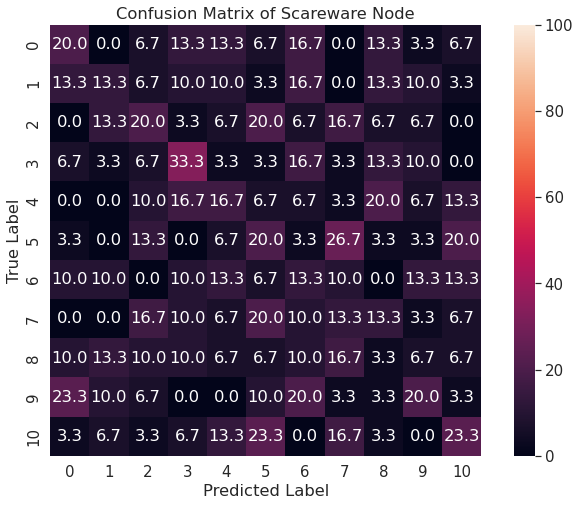

In [370]:
Sc_Xtest_full, Sc_ytest_full = l2_Xtest_full['Scareware'], l2_ytest_full['Scareware']

print(f"Number of Scareware quintuples: {len(Sc_ytest_full)}")

print(f"Number of quintuples after smart labeling: {len(Sc_ytest_full)}")

# Prediction
Scareware_pred_full = Scareware_classifier.predict(Sc_Xtest_full)

# Evaluation
score = accuracy_score(Sc_ytest_full, Scareware_pred_full)
print(classification_report(Sc_ytest_full, Scareware_pred_full))
print(f"Accuracy: {score:.4f}")

# Confusion matrix
mat = confusion_matrix(Sc_ytest_full, Scareware_pred_full, normalize='true')
plt.figure(figsize=(12, 8), dpi=70)
sns.heatmap(mat*100, square=True, annot=True, fmt='.1f', vmin=0, vmax=100, cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Scareware Node')
plt.show()


#### SMSMalware

Number of SMSMalware quintuples: 348
First 20 labels: ['jifake', 'jifake', 'AVpass', 'Benign', 'Beanbot', 'Benign', 'smssniffer', 'Beanbot', 'Benign', 'jifake', 'Benign', 'zsone', 'Benign', 'Benign', 'FakeApp.AL', 'Biige', 'mazarbot', 'Beanbot', 'Benign', 'Pletor']
Number of quintuples after smart labeling: 348
                 precision    recall  f1-score   support

   AVforandroid       0.00      0.00      0.00         5
         AVpass       0.00      0.00      0.00         2
AndroidDefender       0.00      0.00      0.00         4
 AndroidSpy.277       0.00      0.00      0.00         4
        Beanbot       0.14      0.45      0.21        11
         Benign       0.00      0.00      0.00       133
          Biige       0.04      0.14      0.06         7
        Charger       0.00      0.00      0.00         7
         Dowgin       0.00      0.00      0.00         5
          Ewind       0.00      0.00      0.00         2
         FakeAV       0.00      0.00      0.00         2
  

/home/jmpr/miniconda3/envs/ntg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmpr/miniconda3/envs/ntg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmpr/miniconda3/envs/ntg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


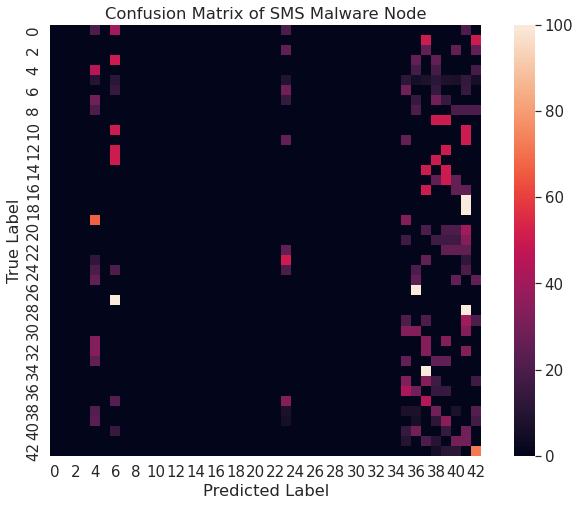

In [371]:
Sm_Xtest, Sm_ytest = l2_Xtest['SMSMalware'], l2_ytest['SMSMalware']

print(f"Number of SMSMalware quintuples: {len(Sm_ytest)}")
print("First 20 labels:", Sm_ytest[0:20])

print(f"Number of quintuples after smart labeling: {len(Sm_ytest)}")

# Prediction
SMSMalware_pred = SMSMalware_classifier.predict(Sm_Xtest)

# Evaluation
score = accuracy_score(Sm_ytest, SMSMalware_pred)
print(classification_report(Sm_ytest, SMSMalware_pred))
print(f"Accuracy: {score:.4f}")

# Confusion matrix
mat = confusion_matrix(Sm_ytest, SMSMalware_pred, normalize='true')
plt.figure(figsize=(12, 8), dpi=70)
sns.heatmap(mat*100, square=True, annot=False, fmt='.1f', vmin=0, vmax=100, cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of SMS Malware Node')
plt.show()


Number of SMSMalware quintuples: 330
First 20 labels: ['smssniffer', 'fakenotify', 'fakemart', 'jifake', 'jifake', 'jifake', 'Beanbot', 'fakeinst', 'Beanbot', 'smssniffer', 'Beanbot', 'fakeinst', 'jifake', 'smssniffer', 'Beanbot', 'zsone', 'fakeinst', 'smssniffer', 'zsone', 'fakemart']
Number of quintuples after smart labeling: 330
              precision    recall  f1-score   support

     Beanbot       0.26      0.30      0.28        30
       Biige       0.15      0.17      0.16        30
   Nandrobox       0.12      0.13      0.12        30
    fakeinst       0.14      0.17      0.15        30
    fakemart       0.29      0.23      0.26        30
  fakenotify       0.23      0.23      0.23        30
      jifake       0.17      0.17      0.17        30
    mazarbot       0.27      0.20      0.23        30
    plankton       0.17      0.17      0.17        30
  smssniffer       0.22      0.20      0.21        30
       zsone       0.45      0.43      0.44        30

    accuracy    

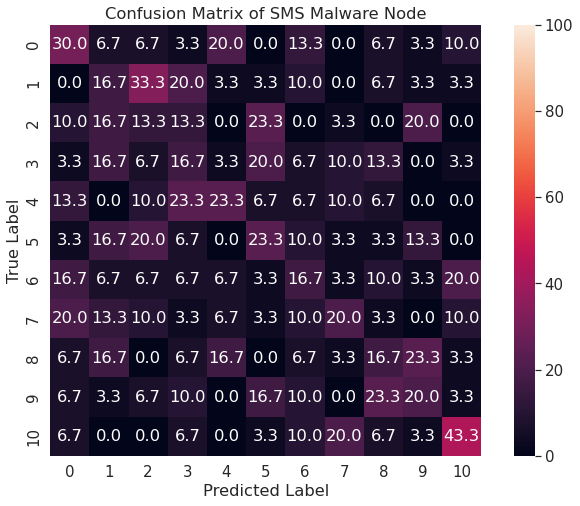

In [372]:
Sm_Xtest_full, Sm_ytest_full = l2_Xtest_full['SMSMalware'], l2_ytest_full['SMSMalware']

print(f"Number of SMSMalware quintuples: {len(Sm_ytest_full)}")
print("First 20 labels:", Sm_ytest_full[0:20])

print(f"Number of quintuples after smart labeling: {len(Sm_ytest_full)}")

# Prediction
SMSMalware_pred_full = SMSMalware_classifier.predict(Sm_Xtest_full)

# Evaluation
score = accuracy_score(Sm_ytest_full, SMSMalware_pred_full)
print(classification_report(Sm_ytest_full, SMSMalware_pred_full))
print(f"Accuracy: {score:.4f}")

# Confusion matrix
mat = confusion_matrix(Sm_ytest_full, SMSMalware_pred_full, normalize='true')
plt.figure(figsize=(12, 8), dpi=70)
sns.heatmap(mat*100, square=True, annot=True, fmt='.1f', vmin=0, vmax=100, cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of SMS Malware Node')
plt.show()


In [373]:
len(Ad_ytest) == len(Adware_pred)

True

In [374]:
fam_ytest = l0_ben_y + Ad_ytest + Ra_ytest + Sm_ytest + Sc_ytest
fam_pred = ['Benign'] * len(l0_ben_y) + list(Adware_pred) + list(Ransomware_pred) + list(SMSMalware_pred) + list(Scareware_pred)

                 precision    recall  f1-score   support

   AVforandroid       0.07      0.07      0.07        30
         AVpass       0.04      0.03      0.04        30
AndroidDefender       0.06      0.07      0.06        30
 AndroidSpy.277       0.09      0.07      0.08        30
        Beanbot       0.14      0.17      0.15        30
         Benign       0.58      0.60      0.59      1260
          Biige       0.04      0.03      0.03        30
        Charger       0.00      0.00      0.00        30
         Dowgin       0.10      0.13      0.11        30
          Ewind       0.07      0.07      0.07        30
         FakeAV       0.06      0.03      0.04        30
        FakeApp       0.03      0.03      0.03        30
     FakeApp.AL       0.03      0.03      0.03        30
   FakeJobOffer       0.00      0.00      0.00        30
     FakeTaoBao       0.00      0.00      0.00        30
          Feiwo       0.04      0.03      0.04        30
       Gooligan       0.36    

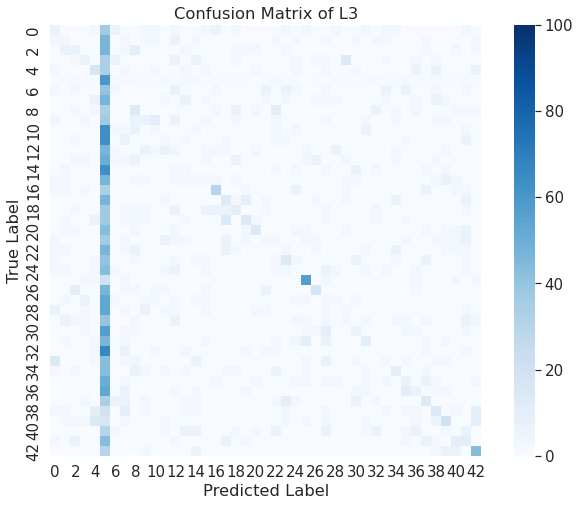

In [375]:
# Overall evaluation
score = accuracy_score(fam_ytest, fam_pred)
print(classification_report(fam_ytest, fam_pred))
print(f"Overall accuracy: {score:.4f}")

# Final confusion matrix
mat = confusion_matrix(fam_ytest, fam_pred, normalize='true')
plt.figure(figsize=(12, 8), dpi=70)
sns.heatmap(mat*100, square=True, annot=False, fmt='.1f', vmin=0, vmax=100, cbar=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of L3')
plt.show()


# Flat Classifier Counterpart

                 precision    recall  f1-score   support

   AVforandroid       0.17      0.03      0.06        30
         AVpass       0.10      0.03      0.05        30
AndroidDefender       0.07      0.03      0.04        30
 AndroidSpy.277       0.18      0.07      0.10        30
        Beanbot       0.10      0.07      0.08        30
         Benign       0.54      0.90      0.68      1260
          Biige       0.00      0.00      0.00        30
        Charger       0.00      0.00      0.00        30
         Dowgin       0.31      0.13      0.19        30
          Ewind       0.10      0.03      0.05        30
         FakeAV       0.17      0.03      0.06        30
        FakeApp       0.20      0.07      0.10        30
     FakeApp.AL       0.00      0.00      0.00        30
   FakeJobOffer       0.00      0.00      0.00        30
     FakeTaoBao       0.00      0.00      0.00        30
          Feiwo       0.17      0.03      0.06        30
       Gooligan       0.69    

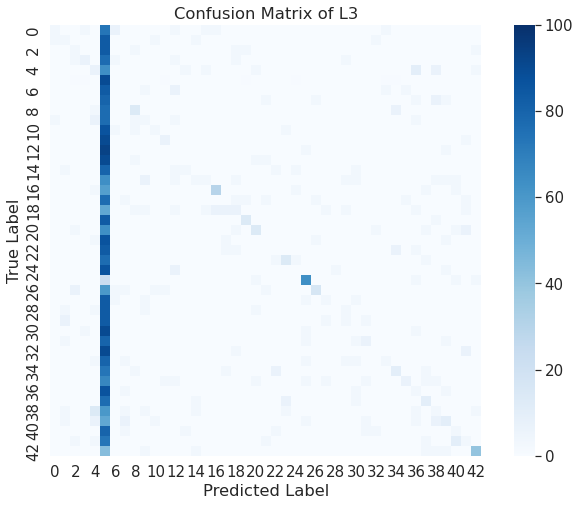

In [376]:
# Smart labeling for training
ytrain_flat = smart_labeling(ytrain, 2)
ytest_flat = smart_labeling(ytest, 2)

# Definition and training of the classifier
flat_classifier = Classifier("Random Forest")
flat_classifier.fit(Xtrain, ytrain_flat)

# Predictionx
flat_ypred = flat_classifier.predict(Xtest)

# Evaluation
score = accuracy_score(ytest_flat, flat_ypred)
print(classification_report(ytest_flat, flat_ypred))
print(f"Accuracy: {score:.4f}")

# Final confusion matrix
mat = confusion_matrix(ytest_flat, flat_ypred, normalize='true')
plt.figure(figsize=(12, 8), dpi=70)
sns.heatmap(mat*100, square=True, annot=False, fmt='.1f', vmin=0, vmax=100, cbar=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of L3')
plt.show()
